In [23]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy import integrate
from lmfit import minimize, Parameters, Parameter, report_fit

pathName = os.getcwd()
print(pathName)

C:\Users\frank\GTREU


# Initialize Five States and Import Data

In [24]:
# Populations of the 5 cities from Google search (https://worldpopulationreview.com/states/)
popNY = 19491339
popWA = 7797100
popCA = 39747267
popNJ = 8936570
popMA = 6979600

dates = ['3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20',
        '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20',
        '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20',
        '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20',
        '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
        '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20',
        '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
        '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20',
        '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20',
        '4/17/20', '4/18/20', '4/19/20', '4/20/20', '4/21/20',
        '4/22/20', '4/23/20', '4/24/20', '4/25/20', '4/26/20',
        '4/27/20', '4/28/20', '4/29/20', '4/30/20', '5/1/20', 
         '5/2/20', '5/3/20', '5/4/20', '5/5/20', '5/6/20',
        '5/7/20', '5/8/20', '5/9/20', '5/10/20', '5/11/20',
        '5/12/20', '5/13/20', '5/14/20', '5/15/20', '5/16/20',
        '5/17/20', '5/18/20', '5/19/20', '5/20/20', '5/21/20',
        '5/22/20', '5/23/20', '5/24/20', '5/25/20', '5/26/20',
        '5/27/20', '5/28/20', '5/29/20', '5/30/20', '5/31/20']

# Scrape CSV file from JHU Github
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
df = pd.read_csv(url, index_col=0)

ny_temp = df.loc[(df['Province_State'] == 'New York')]
wash_temp = df.loc[(df['Province_State'] == 'Washington')]
cali_temp = df.loc[(df['Province_State'] == 'California')]
nj_temp = df.loc[(df['Province_State'] == 'New Jersey')]
mass_temp = df.loc[(df['Province_State'] == 'Massachusetts')]

url2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
dfDeaths = pd.read_csv(url2, index_col=0)

ny_tempDeaths = dfDeaths.loc[(df['Province_State'] == 'New York')]
wash_tempDeaths = dfDeaths.loc[(df['Province_State'] == 'Washington')]
cali_tempDeaths = dfDeaths.loc[(df['Province_State'] == 'California')]
nj_tempDeaths = dfDeaths.loc[(df['Province_State'] == 'New Jersey')]
mass_tempDeaths = dfDeaths.loc[(df['Province_State'] == 'Massachusetts')]

In [148]:
# Fill each state array up with daily corona cases

# New York
ny = []
k=0
tempI = 0
tempD = 0
for i in dates:
    nyI = sum(ny_temp[i]) - tempI
    nyD = sum(ny_tempDeaths[i]) - tempD
    tempnyI = sum(ny_temp[i])
    tempnyD = sum(ny_tempDeaths[i])
    nyS = popNY - nyI - nyD
    insert = [nyS, nyI]#, nyI, nyD]
    ny.append(insert)
    tempI = tempnyI
    tempD = tempnyD
    k += 1

# Washington
wash = []
k=0
for i in dates:
    washI = sum(wash_temp[i])
    washD = sum(wash_tempDeaths[i])
    washS = popWA - washI - washD
    insert = [washS, washI, washI, washD]
    wash.append(insert)
    k += 1
    
# California    
cali = []
k=0
for i in dates:
    caliI = sum(cali_temp[i])
    caliD = sum(cali_tempDeaths[i])
    caliS = popCA - caliI - caliD
    insert = [caliS, caliI, caliI, caliD]
    cali.append(insert)
    k += 1
    
# New Jersey
nj = []
k=0
for i in dates:
    njI = sum(nj_temp[i])
    njD = sum(nj_tempDeaths[i])
    njS = popNJ - njI - njD
    insert = [njS, njI, njI, njD]
    nj.append(insert)
    k += 1

# Massachusetts
mass = []
k=0
for i in dates:
    massI = sum(mass_temp[i])
    massD = sum(mass_tempDeaths[i])
    massS = popMA - massI - massD
    insert = [massS, massI, massI, massD]
    mass.append(insert)
    k += 1

# SEIR Model

In [176]:
# beta is infection rate
# sigma is incubation rate (average duration is 1/sigma)
# gamma is recovery/mortality rate

def SEIR(y, t, beta, sigma, gamma):
    S, E, I, R = y
    N = S+E+I+R
    # Ordinary differential equations
    dS = (-beta * S * I) / N
    dE = ((beta * S * I)/N) - (sigma * E)
    dI = (sigma * E) - (gamma * I)
    dR = gamma * I
    return(dS, dE, dI, dR)

# Parameter Fitting for NY

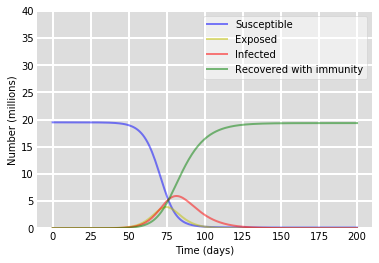

In [178]:
# Run SEIR for NY
N = popNY 
E0 = 100
I0 = 10
R0 = 0
S0 = N - E0 - I0 - R0
sigma = 1/(5)
gamma = 1/(10)
r0 = 5
beta = r0 * gamma
days = 200

# Init parameters for optimization
params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('sigma', value=sigma, min=0, max=10)
params.add('gamma', value=gamma, min=0, max=10)

t = np.linspace(0, days, days)
y0 = S0, E0, I0, R0

# Integrate equations over t
def ode_sol(t, init, params):
    beta, sigma, gamma = params['beta'].value, params['sigma'].value, params['gamma'].value
    out = odeint(SEIR, init, t, args=(beta, sigma, gamma))
    return out

res = ode_sol(t, y0, params)
S, E, I, R = res.T

# Plot data on curves
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (millions)')
ax.set_ylim(0,40)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [166]:
def error(param, init, tspan, data):
    sol = ode_sol(tspan, init, param)
    #print(sol[:, 0:1])
    return (sol[:, 0:2] - data).ravel()

params

name,value,initial value,min,max,vary
beta,0.50000000,0.5,0.00000000,10.0000000,True
sigma,0.20000000,0.2,0.00000000,10.0000000,True
gamma,0.10000000,0.1,0.00000000,10.0000000,True


In [167]:
# Fit model to New York
E0 = 100
# Look at first 3 days of cases
I0 = sum(ny[1][1:3])
R0 = 0
N0 = popNY
days = 91
S0 = N0 - E0 - I0 - R0
tspan = np.arange(0, days, 1)
data = ny
init = [S0, E0, I0, R0]

# Fit the model
result = minimize(error, params, args=(init, tspan, data), method='leastsq')

In [168]:
# Check fitted parameters
result.params

name,value,standard error,relative error,initial value,min,max,vary
beta,7.51909129,0.69746522,(9.28%),0.5,0.00000000,10.0000000,True
sigma,8.11611526,0.64423286,(7.94%),0.2,0.00000000,10.0000000,True
gamma,7.66705989,0.70652094,(9.22%),0.1,0.00000000,10.0000000,True


In [169]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 182
    # variables        = 3
    chi-square         = 3.5150e+09
    reduced chi-square = 19637120.3
    Akaike info crit   = 3059.28866
    Bayesian info crit = 3068.90068
[[Variables]]
    beta:   7.51909129 +/- 0.69746522 (9.28%) (init = 0.5)
    sigma:  8.11611526 +/- 0.64423286 (7.94%) (init = 0.2)
    gamma:  7.66705989 +/- 0.70652094 (9.22%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  1.000
    C(sigma, gamma) = -0.848
    C(beta, sigma)  = -0.840


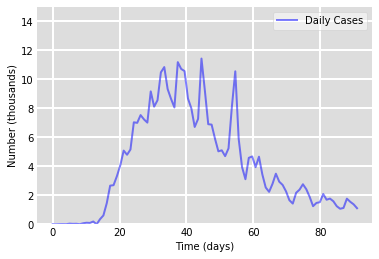

In [170]:
# Plot daily cases for New York
printNY = [0]*len(dates)
k=0

for i in ny:
    printNY[k] = i[1]/1000
    k+=1

t =  np.linspace(0, len(dates), len(dates))
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, printNY, 'b', alpha=0.5, lw=2, label='Daily Cases')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (thousands)')
ax.set_ylim(0,15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

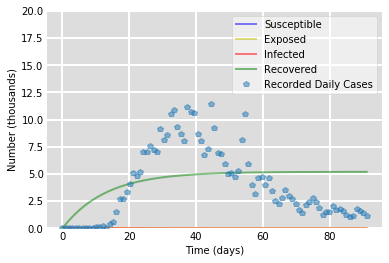

In [179]:
# Plot SEIR model using fitted parameters for NY
E0 = 100
# Look at first 3 days of cases
I0 = sum(ny[1][1:3])
R0 = 0
N0 = popNY
S0 = N0 - E0 - I0 - R0
days = 91
t = np.linspace(0, days, days)
y0 = S0, E0, I0, R0
res = ode_sol(t, y0, result.params)
S, E, I, R = res.T

# Plot data on curves
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(t, printNY, 'p', alpha=0.5, lw=2, label='Recorded Daily Cases')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (thousands)')
ax.set_ylim(0,20)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()